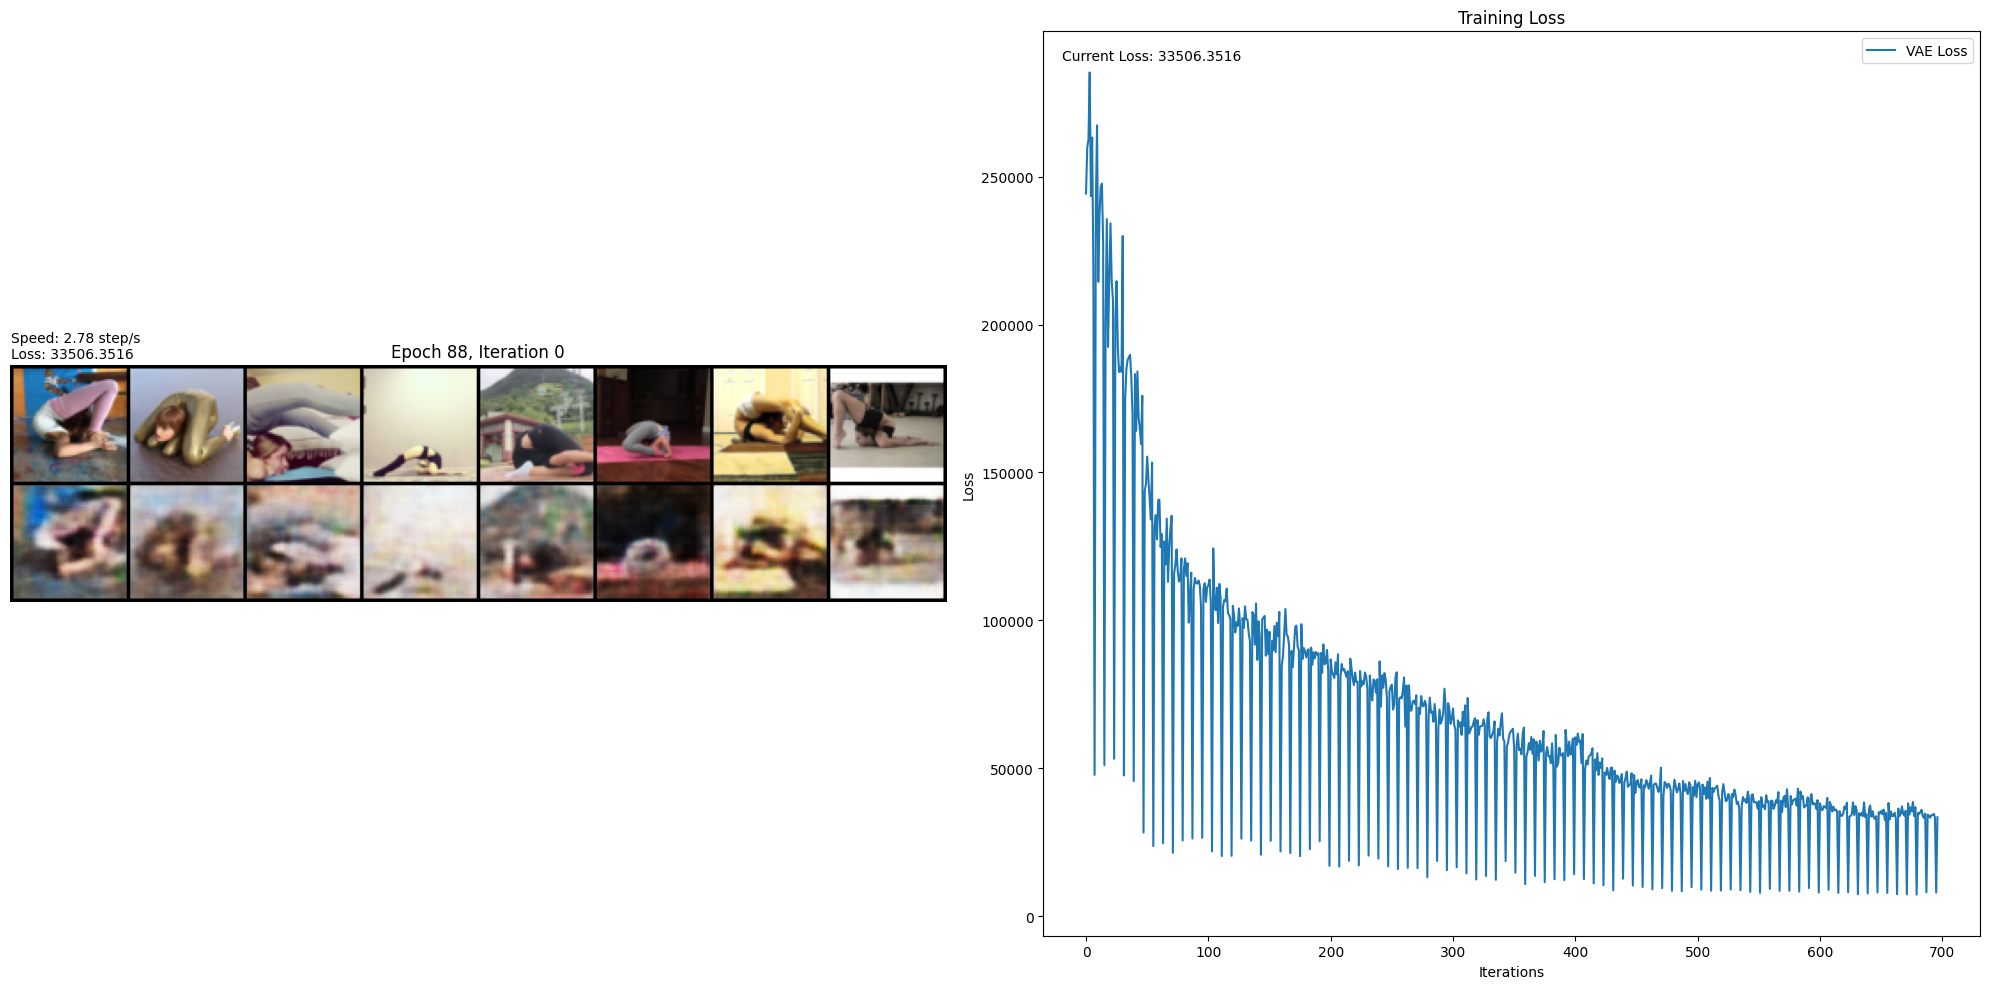

100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


Epoch [88/200], Loss: 7315.3501


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
latent_dim = 100
img_size = 64
channels = 3
batch_size = 64
epochs = 200
lr = 0.0002
beta1 = 0.5

# Set up data loading
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='D:\\Diffusion\\Training\\_datasets\\dreamweaver\\dreamweaver_cont\\backbend-chest-side', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, channels, 4, 2, 1),
            nn.Tanh()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = optimizer = AdamW(vae.parameters(), lr=0.001, weight_decay=0.01) # OptimizerWrapper(vae.parameters(), "adabound", "high_memory", lr=0.001)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training loop
losses = []

# Set up the plot
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.show()

# Initialize variables for speed calculation
start_time = time.time()
steps = 0
speed = 0

for epoch in range(epochs):
    for i, (images, _) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Save loss for plotting
        losses.append(loss.item())
        
        # Calculate speed
        steps += 1
        elapsed_time = time.time() - start_time
        speed = steps / elapsed_time
        
        # Visualize results every 50 iterations
        if i % 50 == 0:
            # Generate and visualize reconstructed images
            with torch.no_grad():
                recon_images = vae(images)[0].cpu()
                
                comparison = torch.cat([images[:8].cpu(), recon_images[:8]])
                grid = make_grid(comparison, nrow=8, normalize=True)
                
                ax1.clear()
                ax1.imshow(grid.permute(1, 2, 0))
                ax1.axis('off')
                ax1.set_title(f"Epoch {epoch+1}, Iteration {i}")
                
                # Add speed and loss values to the image
                info_text = f"Speed: {speed:.2f} step/s\n"
                info_text += f"Loss: {loss.item():.4f}"
                ax1.text(0, -20, info_text, fontsize=10, verticalalignment='top')
            
            # Plot loss curve
            ax2.clear()
            ax2.plot(losses, label='VAE Loss')
            ax2.set_xlabel('Iterations')
            ax2.set_ylabel('Loss')
            ax2.legend()
            ax2.set_title('Training Loss')
            
            # Add current loss value to the plot
            ax2.text(0.02, 0.98, f"Current Loss: {loss.item():.4f}", transform=ax2.transAxes, verticalalignment='top')
            
            plt.tight_layout()
            
            # Update the plot
            fig.canvas.draw()
            fig.canvas.flush_events()
            
            # Display the plot (for Jupyter notebook)
            clear_output(wait=True)
            display(fig)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

plt.ioff()
plt.show()